In [12]:
# --- Cell 1: Import Libraries ---
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import joblib

In [13]:
# --- Cell 2: Fetch Data ---
tickers = ['TSLA', 'BTC-USD', 'USDT-USD']
start_date = '2015-07-01'
end_date = '2025-07-31'
data = yf.download(tickers, start=start_date, end=end_date)['Close']

C:\Users\hp\AppData\Local\Temp\ipykernel_26960\1236297290.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  3 of 3 completed


In [14]:
# --- Cell 3: Helper Function ---
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

In [15]:
def run_models_and_plot(asset, ticker):
    train = asset[:'2023-12-31']
    test = asset['2024-01-01':]

    # LSTM Preparation
    scaler = MinMaxScaler()
    asset_scaled = scaler.fit_transform(asset.values.reshape(-1,1))
    train_size = len(train)
    train_scaled = asset_scaled[:train_size]
    test_scaled = asset_scaled[train_size:]

    seq_length = 30
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)

    # Fit LSTM & Forecast 
    units = 64
    batch_size = 32
    model = Sequential()
    model.add(LSTM(units, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(LSTM(units // 2, return_sequences=False))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=10, batch_size=batch_size, verbose=0)

    lstm_pred = model.predict(X_test)
    lstm_pred_rescaled = scaler.inverse_transform(lstm_pred)
    test_actual_rescaled = scaler.inverse_transform(y_test)

    # Save model and scaler for later prediction
    model.save(f'lstm_{ticker}_model.h5')
    joblib.dump(scaler, f'lstm_{ticker}_scaler.pkl')

    # Plot LSTM
    plt.figure(figsize=(12,5))
    plt.plot(train.index, scaler.inverse_transform(train_scaled), label='Train', color='blue')
    plt.plot(test.index, scaler.inverse_transform(test_scaled), label='Test', color='green')
    plt.plot(test.index[seq_length:], lstm_pred_rescaled, label='LSTM Forecast', color='orange')
    plt.legend()
    plt.title(f'{ticker} LSTM Forecast')
    plt.show()

    lstm_mae = mean_absolute_error(test_actual_rescaled, lstm_pred_rescaled)
    lstm_rmse = np.sqrt(mean_squared_error(test_actual_rescaled, lstm_pred_rescaled))
    lstm_mape = mean_absolute_percentage_error(test_actual_rescaled, lstm_pred_rescaled)

    print(f"{ticker} LSTM MAE: {lstm_mae:.2f}, RMSE: {lstm_rmse:.2f}, MAPE: {lstm_mape:.2f}")

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- TSLA ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


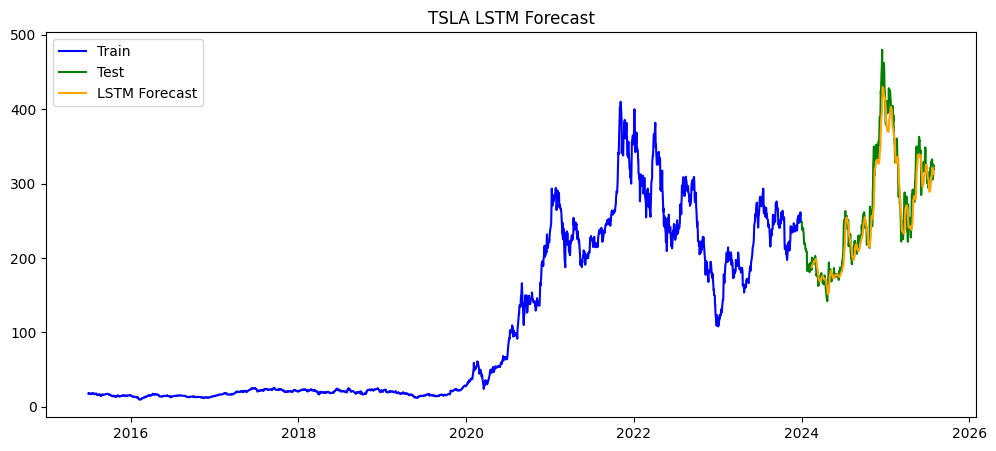

TSLA LSTM MAE: 14.45, RMSE: 20.11, MAPE: 0.05

--- BTC-USD ---


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


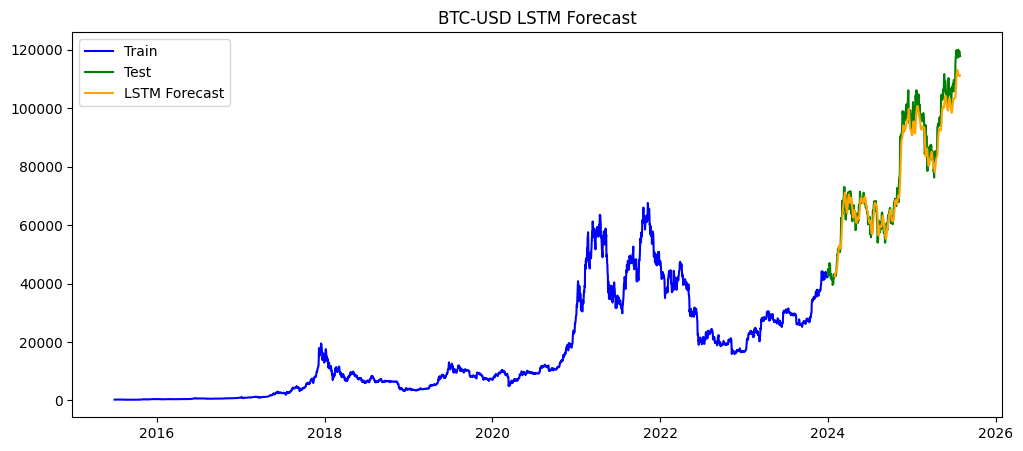

BTC-USD LSTM MAE: 3202.10, RMSE: 4069.76, MAPE: 0.04

--- USDT-USD ---


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


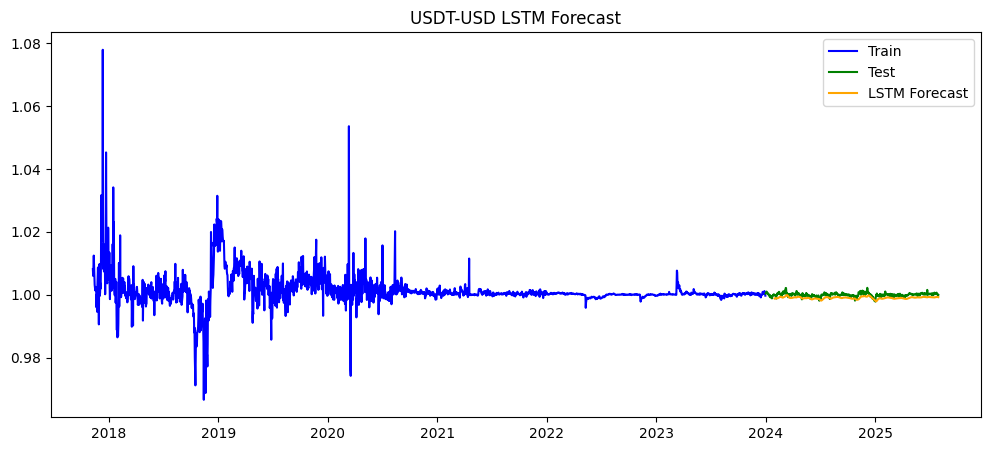

USDT-USD LSTM MAE: 0.00, RMSE: 0.00, MAPE: 0.00


In [16]:
for ticker in tickers:
    print(f"\n--- {ticker} ---")
    asset = data[ticker].dropna()
    run_models_and_plot(asset, ticker)

In [ ]:
# # Prediction function for a given date
#     def predict_for_date(date_str, asset_series, seq_length, ticker):
#         from keras.models import load_model
#         scaler = joblib.load(f'lstm_{ticker}_scaler.pkl')
#         model = load_model(f'lstm_{ticker}_model.h5')
#         date_idx = asset_series.index.get_loc(date_str)
#         seq = asset_series.values[date_idx-seq_length+1:date_idx+1].reshape(-1, 1)
#         seq_scaled = scaler.transform(seq)
#         seq_scaled = seq_scaled.reshape(1, seq_length, 1)
#         pred_scaled = model.predict(seq_scaled)
#         pred = scaler.inverse_transform(pred_scaled)
#         return float(pred[0, 0])

#     # Example usage:
#     # predicted_price = predict_for_date('2025-07-31', asset, seq_length, ticker)
#     # print(f"Predicted {ticker} price for next day after 2025-

IndentationError: unexpected indent (251989689.py, line 2)